In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog

from skimage.filters import threshold_otsu
from skimage.morphology import opening, square
from skimage.measure import label, regionprops

from sklearn.cluster import AffinityPropagation
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, \
    GradientBoostingClassifier, RandomForestClassifier

%matplotlib inline

# Step 0 -- get data

In [4]:
# Create directory for training data
!mkdir -p data
!mkdir -p data

In [5]:
# Get data
!wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip -qO data/vehicles.zip
!wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip -qO data/non-vehicles.zip

In [6]:
# Unzip data
!unzip -q data/vehicles.zip -d data
!rm -rf data/__MACOSX
!unzip -q data/non-vehicles.zip -d data
!rm -rf data/__MACOSX

In [2]:
images_vehicle = glob.glob('data/vehicles/*/*.png')
images_nonvehicle = glob.glob('data/non-vehicles/*/*.png')
print('Total vehicles: {}, Total non-vehicles: {}'.format(len(images_vehicle), len(images_nonvehicle)))

Total vehicles: 8792, Total non-vehicles: 9666


Deviation in class sizes is small so we can keep it without extra balancing

In [3]:
# load one sample image to get shape
sample_image = mpimg.imread(images_vehicle[0])

In [4]:
# get all images data
X = np.zeros((len(images_vehicle) + len(images_nonvehicle), *sample_image.shape), dtype=np.float32)
i = 0
for imgpath in images_vehicle:
    X[i] = mpimg.imread(imgpath)
    i += 1

for imgpath in images_nonvehicle:
    X[i] = mpimg.imread(imgpath)
    i += 1

In [5]:
# generate label data
y = np.hstack((np.ones(len(images_vehicle)), np.zeros(len(images_nonvehicle)))).astype(np.uint8)

In [6]:
# split into train, validation and test sets
RANDOM_STATE = 1234

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print('Train set shapes {}, {}'.format(X_TRAIN.shape, Y_TRAIN.shape))
print('Test set shapes {}, {}'.format(X_TEST.shape, Y_TEST.shape))

Train set shapes (14766, 64, 64, 3), (14766,)
Test set shapes (3692, 64, 64, 3), (3692,)


# Step 1 -- get features

In [7]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [8]:
def draw_hog_examples(image, orient=12, pix_per_cell=6, cell_per_block=2):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls  = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    _, axarr = plt.subplots(1, 5, figsize=(12,3))
    axarr[0].set_title('original')
    axarr[0].imshow(image)
    
    _, gray_hog = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True)
    axarr[1].set_title('gray hog')
    axarr[1].imshow(gray_hog, cmap='gray')
    
    _, h_hog = get_hog_features(hls[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
    axarr[2].set_title('H hog')
    axarr[2].imshow(h_hog, cmap='gray')
    
    _, l_hog = get_hog_features(hls[:,:,1], orient, pix_per_cell, cell_per_block, vis=True)
    axarr[3].set_title('L hog')
    axarr[3].imshow(l_hog, cmap='gray')
    
    _, s_hog = get_hog_features(hls[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)
    axarr[4].set_title('S hog')
    axarr[4].imshow(s_hog, cmap='gray')

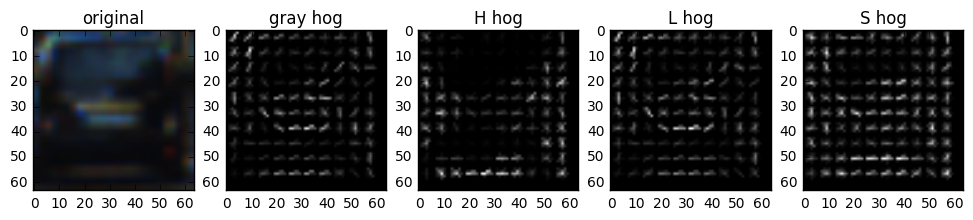

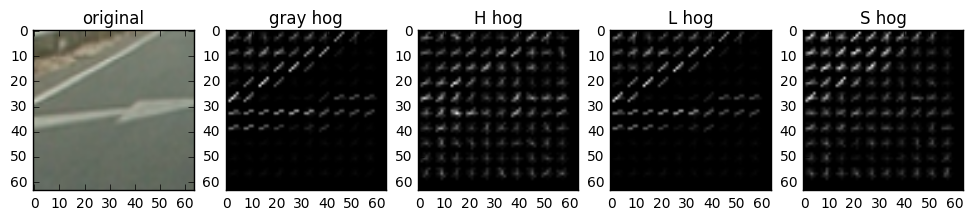

In [9]:
draw_hog_examples(mpimg.imread(images_vehicle[0]))
draw_hog_examples(mpimg.imread(images_nonvehicle[0]))

In [10]:
def get_hog_data(X, colorspace, orient, pixpercell, cellperblock, featuresize):
    Xhog = np.zeros((X.shape[0], featuresize), dtype=np.float32)
    
    for idx in range(X.shape[0]):
        if colorspace == 'gray':
            x = cv2.cvtColor(X[idx], cv2.COLOR_RGB2GRAY)
        else:
            hls = cv2.cvtColor(X[idx], cv2.COLOR_RGB2HLS)
            x = hls[:,:,['h', 'l', 's'].index(colorspace)]
        
        f = get_hog_features(x, orient, pixpercell, cellperblock)
        Xhog[idx] = f
        
    return Xhog

# Step 2 -- train classifier

In [11]:
classifiers = [
#     LinearSVC,
#     DecisionTreeClassifier,
#     BaggingClassifier,
#     ExtraTreesClassifier,
    GradientBoostingClassifier,
#     RandomForestClassifier
]

In [12]:
def examine_hog_params_and_classifiers(colorspace, orient, pixpercell, cellperblock):
    # get vector size, doesnt matter which color space to use
    sample_feature = get_hog_features(cv2.cvtColor(sample_image, cv2.COLOR_RGB2GRAY), orient, pixpercell, cellperblock)
    vector_size = sample_feature.shape[0]
    
    # transform raw pixel data into hog features
    X_train = get_hog_data(X_TRAIN, colorspace, orient, pixpercell, cellperblock, vector_size)
    X_test =  get_hog_data(X_TEST,  colorspace, orient, pixpercell, cellperblock, vector_size)

    # get scaler from training data
    X_scaler = StandardScaler().fit(X_train)

    # transform all X data with scaler
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    print('colorspace {}, orient {}, pixpercell {}, cellperblock {}'.format(colorspace, orient, pixpercell, cellperblock))
    for c in classifiers:
        clf = c()
        clf.fit(X_train, Y_TRAIN)
        print(c, clf.score(X_test, Y_TEST))

In [13]:
for colorspace in ['l']: # ['gray', 'h', 'l', 's']:
    for orient in [10]:
        for pixpercell in [16]: # [4, 6, 8, 10, 12, 14, 16, 18, 20]:
            for cellperblock in [2]: # [1,2,3,4]:
                examine_hog_params_and_classifiers(colorspace, orient, pixpercell, cellperblock)

colorspace l, orient 10, pixpercell 16, cellperblock 2
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'> 0.968309859155


In several experiments I noted that:
* L-channel gives best results for HOG features, grayscale is also good
* GradientBoostingClassifier works best of all
* orient value of 10 gives best results
* more pixpercell produced more accuracy, I used 16
* cells per block value of 2 gives best results

In [14]:
HOG_ORIENT = 10
HOG_PPC = 16
HOG_CPB = 2
HOG_SIZE = 360

In [15]:
X_train = get_hog_data(X_TRAIN, 'l', HOG_ORIENT, HOG_PPC, HOG_CPB, HOG_SIZE)
X_scaler = StandardScaler().fit(X_train)

In [16]:
def preprocess_input(X):
    X = get_hog_data(X, 'l', HOG_ORIENT, HOG_PPC, HOG_CPB, HOG_SIZE)
    X = X_scaler.transform(X)
    return X

In [17]:
X_train = preprocess_input(X_TRAIN)
X_test =  preprocess_input(X_TEST)
clf = GradientBoostingClassifier()
clf.fit(X_train, Y_TRAIN)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [18]:
# Confirm evaluation results
print(clf.score(X_train, Y_TRAIN), clf.score(X_test, Y_TEST))

0.985168630638 0.968309859155


# Sliding window search

In [19]:
IMG_WIDTH = 1280
IMG_HEIGTH = 720
IMG_CENTER = 640
SLW_OVERLAP = .05
SLW_WINDOWS = [
    (96,  256),
    (150, 196),
    (200, 128),
    (230, 96),
]

In [20]:
def get_sliding_windows(img):
    windows = []
    images = []
    
    for bottom_offset, window_size in SLW_WINDOWS:
        step = int(window_size * SLW_OVERLAP)
        total_windows = IMG_WIDTH // step + 1
        
        for i in range(total_windows):
            center = i * step
            deviation = float(center - IMG_CENTER) / IMG_CENTER
            window_width = int((window_size / 2) * (1. + deviation ** 2))
            
            if center - window_width < 0:
                xleft = 0
                xrigh = center + window_width
            elif center + window_width > IMG_WIDTH:
                xleft = center - window_width
                xrigh = IMG_WIDTH
            else:
                xleft = center - window_width
                xrigh = center + window_width
                
            yleft = IMG_HEIGTH - bottom_offset
            yrigh = yleft - window_size
            
            windows.append([(xleft, yleft), (xrigh, yrigh)])
            images.append(img[yrigh:yleft, xleft:xrigh, :])
            # cv2.rectangle(img, (xleft, yleft), (xrigh, yrigh), randcolor, 3)
            
    return windows, images

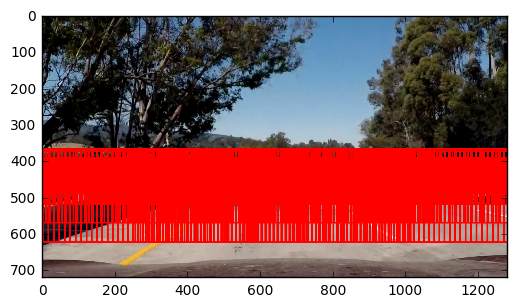

In [21]:
test_img = mpimg.imread('test_images/test5.jpg')
windows, _ = get_sliding_windows(test_img)
for p1, p2 in windows:
    cv2.rectangle(test_img, p1, p2, (255,0,0), 3)
plt.imshow(test_img)

In [22]:
def prepare_image_patch_for_classifier(img):
    if img.shape[0] != 64 or img.shape[1] != 64:
        img = cv2.resize(img, (64, 64))
    img = np.expand_dims(img, axis=0)
        
    return img

In [23]:
def get_vehicles_heatmap_from_image(source_image, probability=.85):
    windows, images = get_sliding_windows(source_image)
    heatmap = np.zeros((source_image.shape[0], source_image.shape[1]), dtype=np.uint8)
    detection_windows = []
    
    i = 0
    for i in range(len(windows)):
        wnd, img = windows[i], images[i]
        
        img = prepare_image_patch_for_classifier(img)
        img = preprocess_input(img)
        
        clfresult = clf.predict(img)[0]
        clfproba = clf.predict_proba(img)[0]
        
        # if clfresult == 1:
        if clfproba[1] > probability:
            xleft, yleft = wnd[0]
            xrigh, yrigh = wnd[1]
            #cv2.rectangle(output_image, wnd[0], wnd[1], (0,0,255), 2)
            heatmap[yrigh:yleft, xleft:xrigh] += 1
            # detection_windows.append(wnd)

    return heatmap #, detection_windows

In [24]:
def get_boundaries_from_heatmap(heatmap):
    if(heatmap.max() == 0):
        return []
    
    thresh = 1 # threshold_otsu(heatmap)
    mask = np.zeros_like(heatmap)
    mask[heatmap > thresh] = 1
    
    labeled = label(mask)
    boxes = []
    
    for region in regionprops(labeled):
        if region.area < 5000:
            continue
        
        minr, minc, maxr, maxc = region.bbox
        boxes.append(((minc, minr), (maxc, maxr)))
    return boxes

# Step 4

In [25]:
class Centroid():
    
    CLOSENESS_DISTANCE = 50
    
    def __init__(self, coords=None):
        self.coords = coords
        
    def init_from_box(self, box):
        p1, p2 = box
        x = int((p1[0] + p2[0]) / 2)
        y = int((p1[1] + p2[1]) / 2)
        self.coords = (x, y)
        
    def get_distance_to_centroid(self, centroid):
        x1, y1 = self.coords
        x2, y2 = centroid.coords
        return np.sqrt((x1-x2)**2 + (y1-y2)**2)

    def is_close_to_centroid(self, centroid):
        return self.get_distance_to_centroid(centroid) < self.CLOSENESS_DISTANCE

In [42]:
class CentroidTracker():
    
    # If 3 of 6 last frames have detections,last centroid is fine to draw
    DRAWABLE_SIZE = 8
    DRAWABLE_TRESHOLD = 3
    
    # If 5 of 15 last frames have detections and no new box found on this frame
    # it is ok to restore last box and use as current frame
    RESTORABLE_SIZE = 15
    RESTORABLE_TRESHOLD = 5
    
    # If last 10 frames have no detection, consider tracker as dead and remove
    DEATH_TOLERANCE = 10
    
    # max number of history
    MAX_HISTORY = 10
    
    def __init__(self, centroid):
        self.centroids = [centroid]
        
        self.last_box = None
        self.detected = False
        self.detections = []
        
    def check_new_centroid(self, centroid):
        if self.detected:
            return False
        
        last_centroid = self.centroids[-1]
        is_close_to_last = centroid.is_close_to_centroid(last_centroid)
        return is_close_to_last
    
    def append_centroid(self, centroid):
        if self.check_new_centroid(centroid):
            self.centroids.append(centroid)
            self.detected = True
            return True
        return False
    
    def is_last_centroid_drawable(self):
        n_last_detections = np.array(self.detections[-self.DRAWABLE_SIZE:]).sum()
        return n_last_detections >= self.DRAWABLE_TRESHOLD
    
    def is_restorable(self):
        if len(self.detections) < self.RESTORABLE_SIZE:
            return False
        
        n_last_detections = np.array(self.detections[-self.RESTORABLE_SIZE:]).sum()
        return n_last_detections >= self.RESTORABLE_TRESHOLD
    
    def is_dead(self):
        # A young tracker is not yet dead
        if len(self.detections) < self.DEATH_TOLERANCE:
            return False
        
        last_steps = self.detections[-self.DEATH_TOLERANCE:]
        is_dead = not np.array(last_steps).any()
        # if is_dead:
        #    print('Tracker is dead!')
        return is_dead
    
    def set_last_box(self, box):
        self.last_box = box
    
    def pre_frame_action(self):
        self.detected = False
    
    def post_frame_action(self):
        self.detections.append(self.detected)
        self.detections = self.detections[-self.MAX_HISTORY:]
        self.centroids  = self.centroids[-self.MAX_HISTORY:]

In [43]:
class ImageProcessor():
    
    def __init__(self):
        self.trackers = []
        self.current_frame = None
        
    def set_frame(self, frame):
        self.current_frame = np.copy(frame)
        
    def draw_box_on_frame(self, box):
        p1, p2 = box
        cv2.rectangle(self.current_frame, p1, p2, (0,0,255), 3)
        
    def draw_averaged_box_on_frame(self, box1, box2):
        a1, a2 = box1
        b1, b2 = box2
        a1, a2, b1, b2 = np.array(a1), np.array(a2), np.array(b1), np.array(b2)
        
        avg1 = 0.9 * a1 + 0.1 * b1
        avg2 = 0.9 * a2 + 0.1 * b2
        
        result_box = ((int(avg1[0]), int(avg1[1])), (int(avg2[0]), int(avg2[1])))
        self.draw_box_on_frame(result_box)
        
    def pre_frame_action(self):
        for t in self.trackers:
            t.pre_frame_action()
        
    def post_frame_action(self):
        alive_trackers = []
        for t in self.trackers:
            t.post_frame_action()
            
            # if tracker is dead (i.e. has no detectins), get rid of it
            if not t.is_dead():
                alive_trackers.append(t)
        self.trackers = alive_trackers
        
    def process_frame(self):
        # First, get boxes from current image
        heatmap = get_vehicles_heatmap_from_image(self.current_frame)
        boxes = get_boundaries_from_heatmap(heatmap)
        
        # reset tracker states before frame processing
        self.pre_frame_action()
        
        # check every found box
        for box in boxes:
            # get centroid
            c = Centroid()
            c.init_from_box(box)
            
            # by default, centroid is considered as a trash
            last_box = None
            is_assigned = False
            is_drawable = False
            
            # try current centroid for every tracker to see which one it can match
            for tracker in self.trackers:
                # if matches, append to that tracker and check if it is drawable
                if tracker.check_new_centroid(c):
                    tracker.append_centroid(c)
                    
                    last_box = tracker.last_box
                    tracker.set_last_box(box)
                    
                    is_assigned = True
                    is_drawable = tracker.is_last_centroid_drawable()
                    # print('Centroid appended. Drawable? {}'.format(is_drawable))
                    break
                # print('No matching trackers')
                    
            # not matched to any tracker -- maybe a new car appeared on the road?
            if not is_assigned:
                # print('New tracker born!')
                newtracker = CentroidTracker(c)
                self.trackers.append(newtracker)
                
            # if centroid was defined as drawable, draw its box!
            if is_drawable:
                if last_box is None:
                    self.draw_box_on_frame(box)
                else:
                    self.draw_box_on_frame(box)
        
        # If no boxes found, check if any tracker is good enough to be restored
        if not len(boxes):
            # print('No boxes found!')
            for t in self.trackers:
                if t.is_restorable():
                    # print('Tracker is restorable, getting last box')
                    self.draw_box_on_frame(t.last_box)
                
        self.post_frame_action()
        return self.current_frame

In [44]:
IP = ImageProcessor()

IP trackers 2


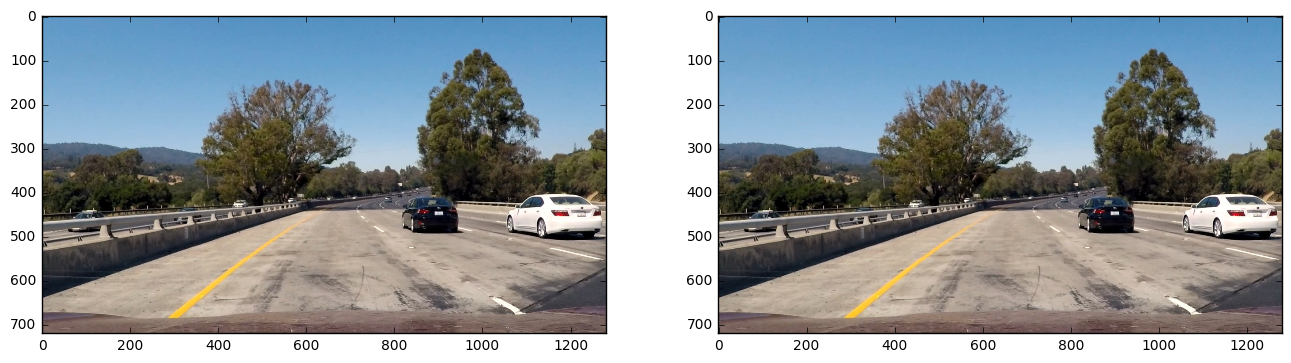

In [45]:
img = mpimg.imread('test_images/test1.jpg')
IP.set_frame(img)
output = IP.process_frame()
print('IP trackers', len(IP.trackers))

f, axarr = plt.subplots(1, 2, figsize=(16,5))
axarr[0].imshow(img)
axarr[1].imshow(output)

In [46]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [47]:
IP = ImageProcessor()

def process_image(image):
    IP.set_frame(image)
    return IP.process_frame()

white_output = 'output_videos/project.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project.mp4
[MoviePy] Writing video output_videos/project.mp4


100%|█████████▉| 1260/1261 [19:38<00:00,  1.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project.mp4 



In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))